## Data Exploration

In [1]:

s3_data ="s3://aegovan-data/human_output/human_interactions_ppi_v2.json"
s3_annotations ="s3://aegovan-data/processed_dataset/input_data_pubtator_annotated_human.txt"
s3_results_prefix = "s3://aegovan-data/processed_dataset/"
human_idmapping_dat = "./data/HUMAN_9606_idmapping.dat"
idmapping_dat="./tmpmap.dat"

In [2]:
!cp $human_idmapping_dat $idmapping_dat
!wc -l $idmapping_dat

 6069679 ./tmpmap.dat


In [3]:
import logging, sys

# Set up logging
logging.basicConfig(level=logging.getLevelName("INFO"), handlers=[logging.StreamHandler(sys.stdout)],
                        format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')


In [4]:
import boto3

def download_single_file(bucket_name_path, local_path):
    index = bucket_name_path.find("://")

    # remove the s3:// if present
    if index > -1:
        bucket_name_path = bucket_name_path[index + 3:]

    key_start_index = bucket_name_path.find("/")
    bucket_name = bucket_name_path
    key = "/"
    if key_start_index > -1:
        bucket_name = bucket_name_path[0:key_start_index]
        key = bucket_name_path[key_start_index + 1:]
        
    client = boto3.resource('s3')
    client.Bucket(bucket_name).download_file(key, local_path)


In [5]:
data_file="input_data.json"
annotations_file="input_data_annotations.txt"

In [6]:
download_single_file(s3_data, data_file)

2021-02-20 18:52:11,980 - botocore.credentials - INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [7]:
download_single_file(s3_annotations, annotations_file)

In [8]:

import pandas as pd

data = pd.read_json(data_file)

print("Total number of records: {}".format(data.shape[0]))

Total number of records: 3381


In [9]:
data.pubmedId.nunique()

850

In [10]:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', 100)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Times']
plt.rcParams.update({'font.size': 12})

## Preliminary data transformations

In [11]:
#TODO: Fix data format
data["pubmedId"] = data["pubmedId"].astype(str)
data["interactionId"] = data["interactionId"].astype(str)
data["isValid"] =  data.isNegative.isin(['false', '0', 'False'])
data = data.drop('isNegative', axis=1)

### Sneak preview of the data

In [12]:
data.head(n=3)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True
2,1585519,phosphorylation,"[{'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been 

In [13]:
data.shape

(3381, 7)

In [14]:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

## Duplicate interactions

In [15]:
def flat_participants_list(list_of_uniprot_dict):
    return frozenset([item["uniprotid"]  for item in list_of_uniprot_dict])
         
data["flatparticpants"]= data["participants"].apply(flat_participants_list)

In [16]:
data.groupby(["pubmedId", "flatparticpants", "interactionType"])\
    .filter(lambda x: len(x) > 1)\
    .groupby(["pubmedId", "flatparticpants", "interactionType"])\
    .size()\
    .sort_values(ascending=False)


pubmedId  flatparticpants         interactionType  
23560844  (P35813, P28482)        dephosphorylation    17
22514276  (Q14524, Q13557)        phosphorylation      12
19407811  (O60566, Q92831)        acetylation          10
20729810  (P43250, P52205)        phosphorylation       9
27373337  (Q86U44, Q9HCE5, None)  methylation           9
                                                       ..
21887822  (P08107, P53350)        phosphorylation       2
          (P53350, P23588)        phosphorylation       2
21806020  (P18031, P05556)        dephosphorylation     2
21782458  (P04637, Q9NRG4)        methylation           2
10366608  (P17612, P48058)        phosphorylation       2
Length: 353, dtype: int64

In [17]:
data.query("pubmedId=='23560844'")[["pubmedId",  "flatparticpants", "interactionType","interactionId"]]\
    .sort_values(by="interactionId")

,pubmedId,flatparticpants,interactionType,interactionId
2348,23560844,"(P35813, P28482)",dephosphorylation,1403258
2349,23560844,"(P35813, P28482)",dephosphorylation,1403266
2350,23560844,"(P35813, Q16539)",dephosphorylation,1403273
2351,23560844,"(P35813, Q16539)",dephosphorylation,1403280
2352,23560844,"(P35813, P28482)",dephosphorylation,1403286
2353,23560844,"(P35813, P28482)",dephosphorylation,1403295
2354,23560844,"(P35813, P28482)",dephosphorylation,1403303
2355,23560844,"(P35813, P28482)",dephosphorylation,1403312
2356,23560844,"(P35813, P28482)",dephosphorylation,1403321
2357,23560844,"(P35813, P28482)",dephosphorylation,1403330


### Number of interactions per paper
**Note: The number of interactions per paper only takes the filtered interactions extracted from the Intact database**

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


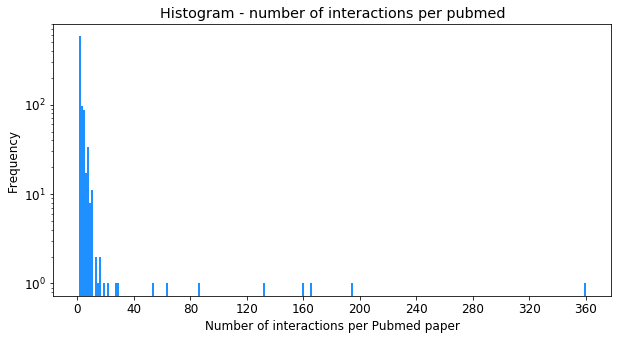

In [18]:
import matplotlib.pyplot as plt
import numpy as np 

ax = plt.axes( yscale='log')
ax.xaxis.set_major_locator(plt.MaxNLocator(10, prune='lower'))

#sns.distplot(data.pubmedId.value_counts().tolist(), bins=100, kde=False, norm_hist=True)

data.pubmedId.value_counts().plot.hist (bins=250,figsize=(10,5), ax=ax, color='dodgerblue')
plt.title('Histogram - number of interactions per pubmed')
plt.xlabel('Number of interactions per Pubmed paper')
plt.ylabel('Frequency')
#plt.show()
plt.savefig('PaperVsInteractions.eps', bbox_inches='tight')
plt.savefig('PaperVsInteractions.png', bbox_inches='tight')
plt.show()

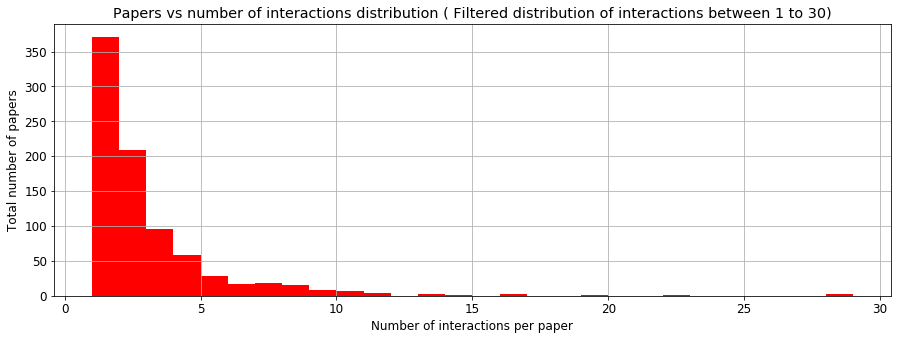

In [19]:
df = data.pubmedId.value_counts().hist (bins=range(1, 30), figsize=(15,5), color = 'red')

plt.title('Papers vs number of interactions distribution ( Filtered distribution of interactions between 1 to 30)')
plt.xlabel('Number of interactions per paper')
plt.ylabel('Total number of papers')

plt.show()

### Interaction Types distribution

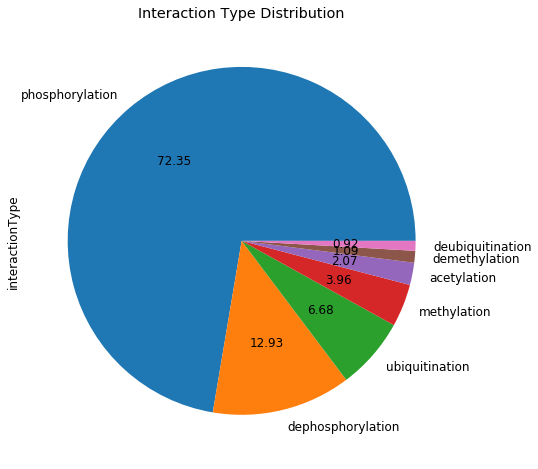

In [20]:
data.interactionType.value_counts().plot.pie(autopct='%.2f',figsize=(8, 8))
plt.title('Interaction Type Distribution')
plt.savefig("Interactiontype.svg")
plt.show()

In [21]:
data.interactionType.value_counts().to_frame()

,interactionType
phosphorylation,2446
dephosphorylation,437
ubiquitination,226
methylation,134
acetylation,70
demethylation,37
deubiquitination,31


### Distinct interaction types per paper

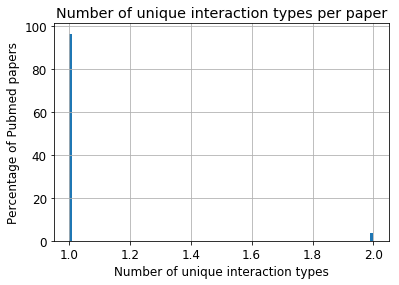

In [22]:
import numpy as np

distinct_no_papers = data['pubmedId'].nunique()

data.groupby('pubmedId')['interactionType'].nunique().hist(bins=100, density=1)
plt.title("Number of unique interaction types per paper")
plt.xlabel('Number of unique interaction types')
plt.ylabel('Percentage of Pubmed papers'.format(distinct_no_papers))
plt.show()


### Postive vs Negative Relationships

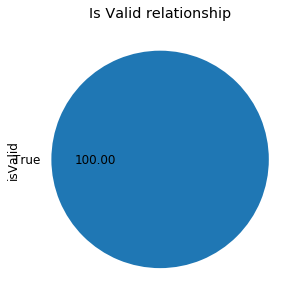

In [23]:
data.isValid.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Is Valid relationship')
plt.show()

### Number of participants per interaction

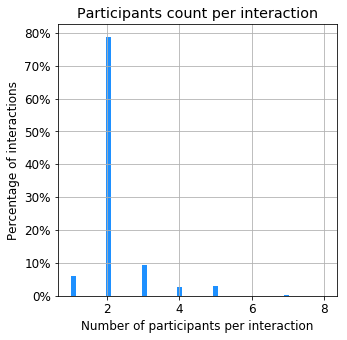

In [24]:
import numpy as np
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())

data['participants_count'] = data["participants"].apply(lambda x: len(x))

data['participants_count'].hist (bins=50, ax=c_ax, figsize=(5,5), color = 'dodgerblue',  weights = np.ones_like(data['participants_count'].index)*100 / len(data['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

### Explore if the abstract contains the trigger word

In [25]:
!pip install nltk==3.4.5

In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

stemmer = PorterStemmer()
print(pd.DataFrame(data.interactionType.unique()).apply(lambda r: stemmer.stem(r.iloc[0].lower()), axis=1))

data["hasTriggerWord"] = data.apply(lambda r: stemmer.stem(r["interactionType"].lower()) in r["pubmedabstract"].lower() , 1)

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/sklearn/feature_extraction/image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated i

0      phosphoryl
1    dephosphoryl
2          methyl
3          acetyl
4     deubiquitin
5       ubiquitin
6        demethyl
dtype: object


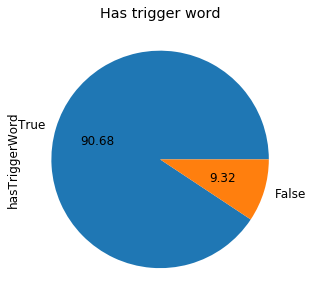

In [27]:
data.hasTriggerWord.value_counts().plot.pie(autopct='%.2f',figsize=(5, 5))
plt.title('Has trigger word')
plt.show()

In [28]:
data.groupby([ 'interactionType','hasTriggerWord']).size().unstack().apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,7.1,92.9
demethylation,2.7,97.3
dephosphorylation,11.4,88.6
deubiquitination,22.6,77.4
methylation,0.7,99.3
phosphorylation,10.1,89.9
ubiquitination,1.8,98.2


### Explore how many of the entity alias are mentioned in the abstract

In [29]:
%%time 

from difflib import SequenceMatcher
def getEntityMentionsCount(r):
    count = 0
    abstract = r["pubmedabstract"].lower()
    abstract_len= len(abstract)
    for p in r["participants"]:
        if p is None or p['alias'] is None : continue
        
        for a in p['alias']:
            alias = a[0].lower()
            s = SequenceMatcher(None, abstract, alias)
            _,_,match_size = s.find_longest_match(0, len(abstract), 0, len(alias))
            if match_size >= 3 and match_size >= len(alias)/2 :
                count += 1
        
    return count
        

data["entityMentionsCount"] = data.apply(lambda r: getEntityMentionsCount(r)  , 1)

CPU times: user 19.8 s, sys: 41 ms, total: 19.9 s
Wall time: 19.7 s


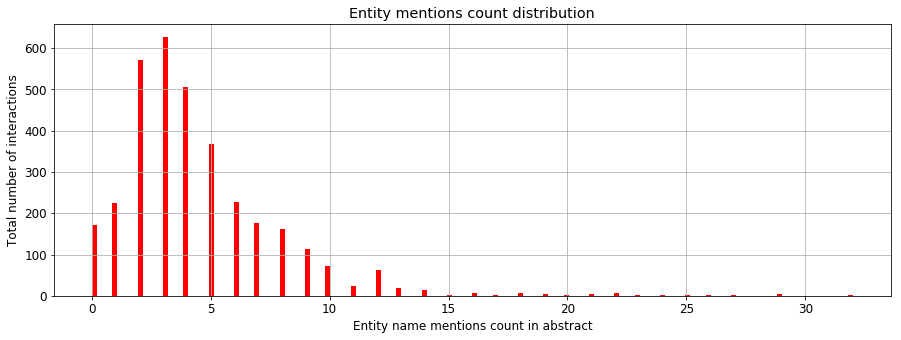

In [30]:
data['entityMentionsCount'].hist ( bins=150, figsize=(15,5), color = 'red')
plt.title('Entity mentions count distribution')
plt.xlabel('Entity name mentions count in abstract')
plt.ylabel('Total number of interactions')

plt.show()

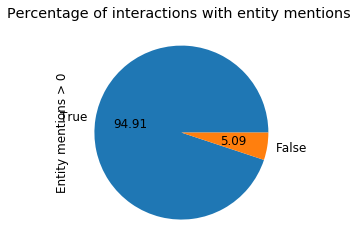

In [31]:
(data['entityMentionsCount'] > 0).value_counts().plot.pie(autopct='%.2f')
plt.title("Percentage of interactions with entity mentions ")
plt.ylabel("Entity mentions > 0")
plt.show()

### Randomly eye ball interactions with no entity mentions

In [32]:

data.query('entityMentionsCount == 0')[['participants','pubmedabstract' ]].sample(n=3)


,participants,pubmedabstract
814,"[{'uniprotid': 'O60293-1', 'alias': [['o60293-1'], ['Zinc finger C3H1 domain-containing protein'], ['ZFC3H1'], ['CCDC131'], ['KIAA0546'], ['PSRC2'], ['Coiled-coil domain-containing protein 131'], ['Proline/serine-rich coiled-coil protein 2']], 'alternative_uniprots': []}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
687,"[{'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}, {'uniprotid': 'Q9GZT3', 'alias': [['slirp_human'], ['SRA stem-loop-interacting RNA-binding protein, mitochondrial'], ['SLIRP'], ['C14orf156'], ['DC23'], ['DC50'], ['PD04872']], 'alternative_uniprots': ['J3KMY7']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."
794,"[{'uniprotid': 'Q15021', 'alias': [['cnd1_human'], ['Condensin complex subunit 1'], ['NCAPD2'], ['CAPD2'], ['KIAA0159'], ['Non-SMC condensin I complex subunit D2'], ['Chromosome condensation-related SMC-associated protein 1'], ['Chromosome-associated protein D2'], ['XCAP-D2 homolog'], ['CNAP1']], 'alternative_uniprots': ['Q8N6U3', 'D3DUR4']}, {'uniprotid': 'P68400', 'alias': [['csk21_human'], ['Casein kinase II subunit alpha'], ['CSNK2A1'], ['CK2A1']], 'alternative_uniprots': ['Q5U065', 'Q14013', 'P19138', 'B4DYS6', 'P20426', 'D3DVV8']}]","Deciphering the kinase-substrate relationship is vital for the study of phosphorylation network. The use of immobilized proteins on protein chip as the library for screening of potential kinase substrates is a tried-and-tested method. However, information on phosphorylation sites is lacking and the creation of the library with proteins of whole proteome by recombinant expression is costly and difficult. In this study, a new solid-phase approach by immobilization of proteins from cell lysate onto beads as a protein library for kinase substrate screening was developed. It was found that consensus phosphorylation sites motif for kinase substrates could be accurately determined and hundreds of in vitro kinase substrates and their phosphorylation sites could be identified by using this method."


In [33]:
data.head(n=2)

,interactionId,interactionType,participants,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount
0,1585513,phosphorylation,"[{'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}, {'uniprotid': 'O43293-2', 'alias': [['o43293-2'], ['Death-associated protein kinase 3'], ['ZIPK-S'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"(Q10728, O43293-2)",2,True,9
1,1585516,phosphorylation,"[{'uniprotid': 'O43293-1', 'alias': [['o43293-1'], ['Death-associated protein kinase 3'], ['ZIPK-L'], ['DAPK3'], ['ZIPK'], ['DAP-like kinase'], ['MYPT1 kinase'], ['Zipper-interacting protein kinase']], 'alternative_uniprots': []}, {'uniprotid': 'Q10728', 'alias': [['mypt1_rat'], ['Protein phosphatase 1 regulatory subunit 12A'], ['Ppp1r12a'], ['Mbs'], ['Mypt1'], ['Myosin phosphatase-targeting subunit 1'], ['Protein phosphatase myosin-binding subunit'], ['MBSP'], ['Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110'], ['Protein phosphatase subunit 1M']], 'alternative_uniprots': ['Q62937', 'Q9WU33']}]",17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"(Q10728, O43293-1)",2,True,9


## Data Transformation

### Drop duplicates by ["pubmedId", "flatparticpants", "interactionType"]

In [34]:
data.shape

(3381, 11)

In [35]:
process_map =[]
process_map.append({"name": "Initial", "count": len(data) })

In [36]:
filtered = data.drop_duplicates(subset=["pubmedId", "flatparticpants", "interactionType"], keep='last')
process_map.append({"name": "Drop duplicates (pubmedId, participant uniprots, interactionType)", 
             "count": len(filtered) })

filtered.shape

(2797, 11)

### Filter interactions with  participants != 2

In [37]:
filtered = filtered[~filtered.pubmedId.isin( filtered.query('participants_count > 2').pubmedId)]

process_map.append({"name": "Drop abstracts that have n-ary relationship n > 2",
                    "count": len(filtered) })

filtered.shape

(2217, 11)

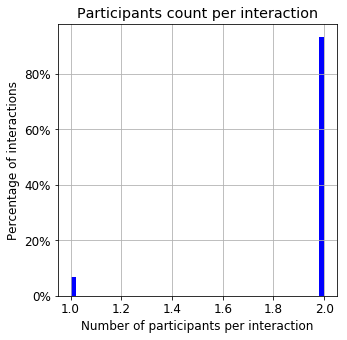

In [38]:
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,1, figsize=(15,5))



c_ax= ax
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
filtered['participants_count'].hist (bins=50, figsize=(5,5), ax=c_ax, color = 'blue',  weights = np.ones_like(filtered['participants_count'].index)*100 / len(filtered['participants_count'].index))
plt.title("Participants count per interaction")
plt.xlabel('Number of participants per interaction')
plt.ylabel('Percentage of interactions')
plt.savefig("ParticipantsPerInteraction.eps")
plt.show()

###  Flatten partcipants into participant 1 and particpiant 2

In [39]:
from datatransformer.jsonPPIFlattenTransformer import IntactJsonPpiFlattenTransformer
 

sut = IntactJsonPpiFlattenTransformer()

data_transformed = sut.transform(filtered)


In [40]:
data_transformed.head(n=2)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[Q10728, O43293-2]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]"
1,1585516,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[Q10728, O43293-1]",2,True,9,O43293-1,Q10728,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]"


In [41]:
data_transformed.shape

(2217, 14)

### Remove records where the participantId is null

In [42]:
data_transformed.shape

(2217, 14)

In [43]:
data_filtered = data_transformed[data_transformed.participant1Id.notnull() & data_transformed.participant2Id.notnull() ]
process_map.append({"name": "Drop interactions where participant Unitprot identifiers are null",
                    "count": len(data_filtered) })
data_filtered.shape

(2155, 14)

In [44]:
data_filtered.head(n=2)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[Q10728, O43293-2]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]"
1,1585516,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[Q10728, O43293-1]",2,True,9,O43293-1,Q10728,"[[o43293-1], [Death-associated protein kinase 3], [ZIPK-L], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]"


### Normalise abstract

In [45]:

def normalise_absract(data, enity_annotations_file):
    from datatransformer.abstractGeneNormaliser import AbstractGeneNormaliser
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper
    from datatransformer.ncbiGeneUniprotMapper import NcbiGeneUniprotMapper


    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.textGeneNormaliser import TextGeneNormaliser


    import os
    
 
    localdb = idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
        
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))
        
        
        # 
        normaliser = AbstractGeneNormaliser(annotations_json)
        normaliser.text_gene_normaliser = TextGeneNormaliser(geneIdConverter = mapper) 
        result = normaliser.transform(data)
        
       

        return result

In [46]:
%%time

data_filtered = normalise_absract(data_filtered.copy(deep=True), annotations_file)

2021-02-20 18:52:46,918 - datatransformer.abstractGeneNormaliser - INFO - Starting transformation..
2021-02-20 18:52:50,200 - datatransformer.abstractGeneNormaliser - INFO - Completed normalised abstract...
2021-02-20 18:52:50,201 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations ...
2021-02-20 18:52:50,380 - datatransformer.abstractGeneNormaliser - INFO - Adding annotations_abstract...
2021-02-20 18:52:50,410 - datatransformer.abstractGeneNormaliser - INFO - Adding num_unique_gene_normalised_id...
2021-02-20 18:52:50,420 - datatransformer.abstractGeneNormaliser - INFO - Adding num_gene_normalised_id...
2021-02-20 18:52:50,427 - datatransformer.abstractGeneNormaliser - INFO - Gene Id links...
2021-02-20 18:52:50,445 - datatransformer.abstractGeneNormaliser - INFO - Completed transformation
CPU times: user 3.51 s, sys: 43.3 ms, total: 3.56 s
Wall time: 3.56 s


In [47]:
data_filtered.shape

(2155, 20)

In [48]:
data_filtered.head(n=3)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map
0,1585513,phosphorylation,17126281,None,"Zipper-interacting protein kinase (ZIP kinase) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that ZIP kinase also plays a role in regulating myosin phosphorylation. Here, we found novel ZIP kinase isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to myosin phosphatase targeting subunit 1(MYPT1) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to myosin. These results indicate that a leucine zipper is not critical for the binding of ZIP kinase to MYPT1 and myosin. Consistently, hZIPK-S localized with stress-fibers where they co-localized with myosin. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to MYPT1, while the myosin binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of myosin phosphorylation.",True,"[Q10728, O43293-2]",2,True,9,Q10728,O43293-2,"[[mypt1_rat], [Protein phosphatase 1 regulatory subunit 12A], [Ppp1r12a], [Mbs], [Mypt1], [Myosin phosphatase-targeting subunit 1], [Protein phosphatase myosin-binding subunit], [MBSP], [Serine/threonine protein phosphatase PP1 smooth muscle regulatory subunit M110], [Protein phosphatase subunit 1M]]","[[o43293-2], [Death-associated protein kinase 3], [ZIPK-S], [DAPK3], [ZIPK], [DAP-like kinase], [MYPT1 kinase], [Zipper-interacting protein kinase]]","O43293 (O43293) has been thought to be involved in apoptosis and the C-terminal leucine zipper motif is important for its function. Recent studies have revealed that O43293 also plays a role in regulating Q7Z406 phosphorylation. Here, we found novel O43293 isoform in which the C-terminal non-kinase domain containing a leucine zipper is eliminated (hZIPK-S). hZIPK-S binds to O14974(O14974) similar to the long isoform (hZIPK-L). In addition, we found that hZIPK-S as well as hZIPK-L bind to Q7Z406. These results indicate that a leucine zipper is not critical for the binding of O43293 to O14974 and Q7Z406. Consistently, hZIPK-S localized with stress-fibers where they co-localized with Q7Z406. The residues 278-311, the C-terminal side of the kinase domain common to the both isoforms, is involved in the binding to O14974, while the Q7Z406 binding domain is within the kinase domain. These results suggest that the newly found hZIPK-S as well as the long isoform play an important role in the regulation of Q7Z406 phosphorylation.","[{'start': '0', 'end': '33', 'name': 'Zipper-interacting protein kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '35', 'end': '45', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '197', 'end': '207', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '240', 'end': '246', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '285', 'end': '295', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '416', 'end': '454', 'name': 'myosin phosphatase targeting subunit 1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '455', 'end': '460', 'name': 'MYPT1', 'type': 'Gene', 'normalised_id': '4659'}, {'start': '563', 'end': '569', 'name': 'myosin', 'type': 'Gene', 'normalised_id': '79784'}, {'start': '651', 'end': '661', 'name': 'ZIP kinase', 'type': 'Gene', 'normalised_id': '1613'}, {'start': '665', 'end': '670', 'name': 'MYPT1', 'type': 'Gene', 'normalised_i

In [49]:
data_filtered.query("interactionType == 'acetylation'").shape

(41, 20)

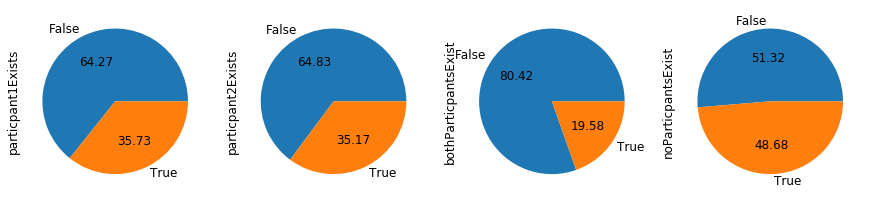

In [50]:

fig, ax =  plt.subplots( 1,4, figsize=(15,5))

tmp = pd.DataFrame()

data_filtered["particpant1Exists"] = data_filtered.apply(lambda r: r["participant1Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant1Exists"].value_counts().plot.pie(ax=ax[0], autopct='%.2f')

data_filtered["particpant2Exists"] = data_filtered.apply(lambda r: r["participant2Id"] in r["normalised_abstract"]   , 1)
data_filtered["particpant2Exists"].value_counts().plot.pie(ax=ax[1], autopct='%.2f')


data_filtered["bothParticpantsExist"] = data_filtered.apply(lambda r: r["particpant2Exists"] and r["particpant1Exists"]   , 1)
data_filtered["bothParticpantsExist"].value_counts().plot.pie(ax=ax[2], autopct='%.2f')

data_filtered["noParticpantsExist"] = data_filtered.apply(lambda r: not (r["particpant2Exists"] or r["particpant1Exists"])   , 1)
data_filtered["noParticpantsExist"].value_counts().plot.pie(ax=ax[3], autopct='%.2f')


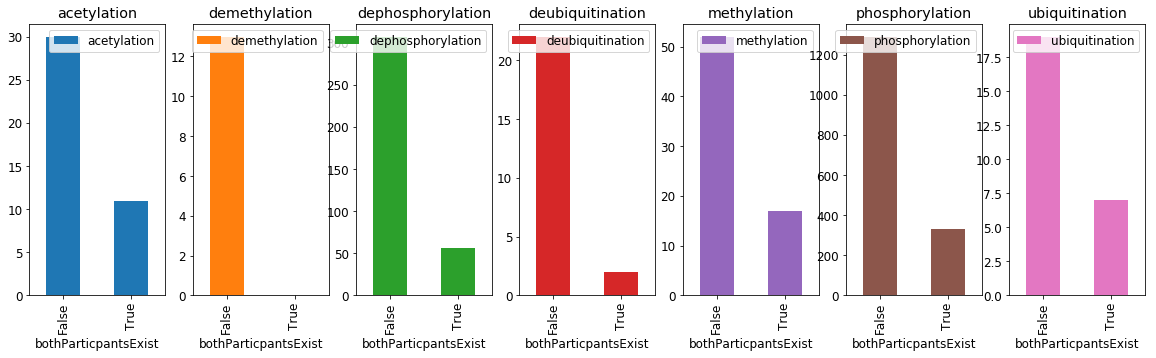

In [51]:
fig, ax = plt.subplots(1,7, figsize=(20,5))

data_filtered.groupby([ "bothParticpantsExist", 'interactionType']).size().unstack().plot.bar(subplots=True, ax=ax)
plt.show()

In [52]:
data_filtered.query("particpant2Exists == False").sample(4)

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
2098,2595032,phosphorylation,16641105,Phosphorylation of TNF-alpha converting enzyme by gastrin-releasing peptide induces amphiregulin release and EGF receptor activation.,"G protein-coupled receptors induce EGF receptor (EGFR) signaling, leading to the proliferation and invasion of cancer cells. Elucidation of the mechanism of EGFR activation by G protein-coupled receptors may identify new signaling paradigms. A gastrin-releasing peptide (GRP)/GRP receptor-mediated autocrine pathway was previously described in squamous cell carcinoma of head and neck. In the present study, we demonstrate that TNF-alpha converting enzyme (TACE), a disintegrin and metalloproteinse-17, undergoes a Src-dependent phosphorylation that regulates release of the EGFR ligand amphiregulin upon GRP treatment. Further investigation reveals the phosphatidylinositol 3-kinase (PI3-K) as the intermediate of c-Src and TACE, contributing to their association and TACE phosphorylation. Phosphoinositide-dependent kinase 1 (PDK1), a downstream target of PI3-K, has been identified as the previously undescribed kinase to directly phosphorylate TACE upon GRP treatment. These findings suggest a signaling cascade of GRP-Src-PI3-K-PDK1-TACE-amphiregulin-EGFR with multiple points of interaction, translocation, and phosphorylation. Furthermore, knockdown of PDK1 augmented the antitumor effects of the EGFR inhibitor erlotinib, indicating PDK1 as a therapeutic target to improve the clinical response to EGFR inhibitors.",True,"[P78536-1, O15530]",2,True,5,P78536-1,O15530,"[[p78536-1], [Disintegrin and metalloproteinase domain-containing protein 17], [ADAM17], [CSVP], [Snake venom-like protease], [TACE], [TNF-alpha convertase], [TNF-alpha-converting enzyme]]","[[pdpk1_human], [3-phosphoinositide-dependent protein kinase 1], [PDPK1], [PDK1]]","G protein-coupled receptors induce P00533 (P00533) signaling, leading to the proliferation and invasion of cancer cells. Elucidation of the mechanism of P00533 activation by G protein-coupled receptors may identify new signaling paradigms. A P07492 (P07492)/P07492 receptor-mediated autocrine pathway was previously described in squamous cell carcinoma of head and neck. In the present study, we demonstrate that P78536 (P78536), a disintegrin and metalloproteinse-17, undergoes a Src-dependent phosphorylation that regulates release of the P00533 ligand amphiregulin upon P07492 treatment. Further investigation reveals the P42336 (P42336) as the intermediate of P12931 and P78536, contributing to their association and P78536 phosphorylation. Q15118 (Q15118), a downstream target of P42336, has been identified as the previously undescribed kinase to directly phosphorylate P78536 upon P07492 treatment. These findings suggest a signaling cascade of P07492-Src-P42336-Q15118-P78536-amphiregulin-P00533 with multiple points of interaction, translocation, and phosphorylation. Furthermore, knockdown of Q15118 augmented the antitumor effects of the P00533 inhibitor erlotinib, indicating Q15118 as a therapeutic target to improve the clinical response to P00533 inhibitors.","[{'start': '35', 'end': '47', 'name': 'EGF receptor', 'type': 'Gene', 'normalised_id': '1956'}, {'start': '49', 'end': '53', 'name': 'EGFR', 'type': 'Gene', 'normalised_id': '1956'}, {'start': '157', 'end': '161', 'name': 'EGFR', 'type': 'Gene', 'normalised_id': '1956'}, {'start': '244', 'end': '269', 'name': 'gastrin-releasing peptide', 'type': 'Gene', 'normalised_id': '2922'}, {'start': '271', 'end': '274', 'name': 'GRP', 'type': 'Gene', 'normalised_id': '2922'}, {'start': '276', 

### Remove abstracts where both participants do not exists

In [53]:
data_filtered =  data_filtered.query('bothParticpantsExist == True')
process_map.append({"name": "Drop interactions where the participant UniprotID does not exist in abstract",
                    "count": len(data_filtered) })
data_filtered.shape

(422, 24)

In [54]:
data_filtered.query("interactionType == 'acetylation'").shape

(11, 24)

In [55]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422}]

### Remove self relations

In [56]:
data_filtered =  data_filtered.query('participant1Id != participant2Id')
process_map.append({"name": "Drop interactions where participant1 = participant2 (self relations)",
                    "count": len(data_filtered) })

data_filtered.shape

(302, 24)

In [57]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422},
 {'name': 'Drop interactions where participant1 = participant2 (self relations)',
  'count': 302}]

In [58]:
data_filtered.query("interactionType == 'acetylation'").shape

(8, 24)

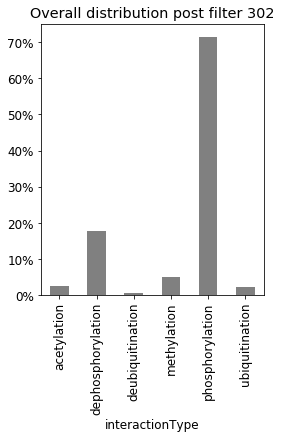

In [59]:
fig, ax = plt.subplots( 1,1, figsize=(4,5))

c_ax= ax
c_ax.set_title('Overall distribution post filter {}'.format(data_filtered.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))

data_filtered.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(data_filtered.interactionType))).plot.bar(ax=c_ax, color='gray')


plt.savefig("Interactiontype_postfilter.eps", bbox_inches='tight')
plt.savefig("Interactiontype_postfilter.png", bbox_inches='tight')


plt.show()

In [60]:
data_filtered.groupby(['interactionType']).size()

interactionType
acetylation            8
dephosphorylation     54
deubiquitination       2
methylation           15
phosphorylation      216
ubiquitination         7
dtype: int64

#### Check how many contain the trigger word

In [61]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0)

hasTriggerWord,False,True
interactionType,,
acetylation,1,7
dephosphorylation,10,44
deubiquitination,0,2
methylation,0,15
phosphorylation,12,204
ubiquitination,0,7


In [62]:
data_filtered.groupby([ 'interactionType','hasTriggerWord']).size().unstack(fill_value = 0).apply(lambda x: round(x/sum(x),3)*100, axis=1)


hasTriggerWord,False,True
interactionType,,
acetylation,12.5,87.5
dephosphorylation,18.5,81.5
deubiquitination,0.0,100.0
methylation,0.0,100.0
phosphorylation,5.6,94.4
ubiquitination,0.0,100.0


In [63]:
data_filtered.query('pubmedId == "17126281"')

,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist


In [64]:
data_filtered.query("interactionType == 'acetylation'")[["interactionType", "pubmedId", "pubmedTitle",
                                                         "participant1Id", "participant2Id" ]]

,interactionType,pubmedId,pubmedTitle,participant1Id,participant2Id
715,acetylation,20856196,None,Q09472,P27695
797,acetylation,26829474,Acetylation of Aurora B by TIP60 ensures accurate chromosomal segregation.,Q96GD4,Q92993
1228,acetylation,22771473,None,Q92831,P63241
1298,acetylation,12471024,None,P13569,Q5T2W1
1415,acetylation,19407811,None,O60566,Q92831
1557,acetylation,21157427,None,Q01130,Q92993
1573,acetylation,23441852,None,Q09472,P61201
1632,acetylation,11804596,None,O15350,Q09472


### Verify no duplicates

In [65]:
duplicates = data_filtered.groupby(["interactionType", "pubmedId", "participant1Id", "participant2Id"])\
    .filter(lambda x: len(x) > 1)\
    .groupby(["interactionType", "pubmedId", "participant1Id", "participant2Id"]).size()

assert len(duplicates)==0

In [66]:
process_map

[{'name': 'Initial', 'count': 3381},
 {'name': 'Drop duplicates (pubmedId, participant uniprots, interactionType)',
  'count': 2797},
 {'name': 'Drop abstracts that have n-ary relationship n > 2', 'count': 2217},
 {'name': 'Drop interactions where participant Unitprot identifiers are null',
  'count': 2155},
 {'name': 'Drop interactions where the participant UniprotID does not exist in abstract',
  'count': 422},
 {'name': 'Drop interactions where participant1 = participant2 (self relations)',
  'count': 302}]

### Split Train/Test/validation

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

unique_pubmed = data_filtered.pubmedId.unique()
stratified =  [ data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in unique_pubmed]
trainpubmed, valpubmed  = train_test_split(unique_pubmed,  test_size=.1,
                                                        random_state=777, stratify=stratified)


stratified =  [data_filtered.query("pubmedId == '{}'".format(p))['interactionType'].iloc[0] for p in trainpubmed]
trainpubmed, testpubmed = train_test_split(trainpubmed,  test_size=.2,
                                                        random_state=777, stratify=stratified)

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the preci

In [68]:
data_filtered.query("interactionType == 'demethylation'")['pubmedId'].unique()

array([], dtype=object)

In [69]:
data_filtered.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['15103385', '16213503', '14603323', '11894096', '11882901',
       '16601676', '11027293'], dtype=object)

In [70]:
train = data_filtered[data_filtered['pubmedId'].isin(trainpubmed)]
test = data_filtered[data_filtered['pubmedId'].isin(testpubmed)]
val = data_filtered[data_filtered['pubmedId'].isin(valpubmed)]




In [71]:
train.query("interactionType == 'ubiquitination'")['pubmedId'].unique()

array(['16213503', '11894096', '11882901', '16601676', '11027293'],
      dtype=object)

In [72]:
val.query("interactionType == 'ubiquitination'")


,interactionId,interactionType,pubmedId,pubmedTitle,pubmedabstract,isValid,flatparticpants,participants_count,hasTriggerWord,entityMentionsCount,participant1Id,participant2Id,participant1Alias,participant2Alias,normalised_abstract,annotations,annotations_abstract,num_unique_gene_normalised_id,num_gene_normalised_id,gene_to_uniprot_map,particpant1Exists,particpant2Exists,bothParticpantsExist,noParticpantsExist
974,130690,ubiquitination,15103385,None,"COP1 (constitutively photomorphogenic 1) is a RING-finger-containing protein that functions to repress plant photomorphogenesis, the light-mediated programme of plant development. Mutants of COP1 are constitutively photomorphogenic, and this has been attributed to their inability to negatively regulate the proteins LAF1 (ref. 1) and HY5 (ref. 2). The role of COP1 in mammalian cells is less well characterized. Here we identify the tumour-suppressor protein p53 as a COP1-interacting protein. COP1 increases p53 turnover by targeting it for degradation by the proteasome in a ubiquitin-dependent fashion, independently of MDM2 or Pirh2, which are known to interact with and negatively regulate p53. Moreover, COP1 serves as an E3 ubiquitin ligase for p53 in vitro and in vivo, and inhibits p53-dependent transcription and apoptosis. Depletion of COP1 by short interfering RNA (siRNA) stabilizes p53 and arrests cells in the G1 phase of the cell cycle. Furthermore, we identify COP1 as a p53-inducible gene, and show that the depletion of COP1 and MDM2 by siRNA cooperatively sensitizes U2-OS cells to ionizing-radiation-induced cell death. Overall, these results indicate that COP1 is a critical negative regulator of p53 and represents a new pathway for maintaining p53 at low levels in unstressed cells.",True,"[P04637, Q8NHY2]",2,True,5,Q8NHY2,P04637,"[[cop1_human], [E3 ubiquitin-protein ligase COP1], [COP1], [Constitutive photomorphogenesis protein 1 homolog], [RFWD2], [RING finger and WD repeat domain protein 2], [RING finger protein 200], [RING-type E3 ubiquitin transferase RFWD2], [RNF200]]","[[p53_human], [Cellular tumor antigen p53], [TP53], [P53], [Tumor suppressor p53], [Phosphoprotein p53], [Antigen NY-CO-13]]","Q8NHY2 (Q8NHY2) is a RING-finger-containing protein that functions to repress plant photomorphogenesis, the light-mediated programme of plant development. Mutants of Q8NHY2 are constitutively photomorphogenic, and this has been attributed to their inability to negatively regulate the proteins LAF1 (ref. 1) and HY5 (ref. 2). The role of Q8NHY2 in mammalian cells is less well characterized. Here we identify the tumour-suppressor protein P04637 as a Q8NHY2-interacting protein. Q8NHY2 increases P04637 turnover by targeting it for degradation by the proteasome in a ubiquitin-dependent fashion, independently of Q00987 or Q96PM5, which are known to interact with and negatively regulate P04637. Moreover, Q8NHY2 serves as an E3 ubiquitin ligase for P04637 in vitro and in vivo, and inhibits P04637-dependent transcription and apoptosis. Depletion of Q8NHY2 by short interfering RNA (siRNA) stabilizes P04637 and arrests cells in the G1 phase of the cell cycle. Furthermore, we identify Q8NHY2 as a P04637-inducible gene, and show that the depletion of Q8NHY2 and Q00987 by siRNA cooperatively sensitizes U2-OS cells to ionizing-radiation-induced cell death. Overall, these results indicate that Q8NHY2 is a critical negative regulator of P04637 and represents a new pathway for maintaining P04637 at low levels in unstressed cells.","[{'start': '0', 'end': '4', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '6', 'end': '39', 'name': 'constitutively photomorphogenic 1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '191', 'end': '195', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '361', 'end': '365', 'name': 'COP1', 'type': 'Gene', 'normalised_id': '64326'}, {'start': '369', 'end': '378', 'name': 'mammalian', 'type': 'Species', 'normalised_id': '9606'

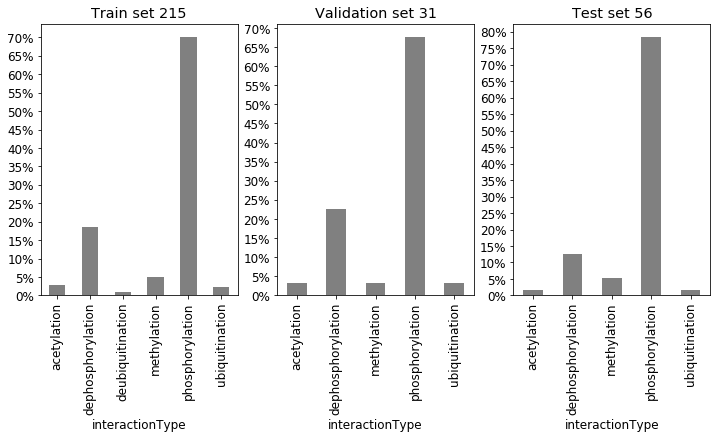

In [73]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(12,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set {}'.format(train.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
train.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(train.interactionType))).plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set {}'.format(val.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
val.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(val.interactionType))).plot.bar(ax=c_ax, color='gray')



c_ax = ax[2] 
c_ax.set_title('Test set {}'.format(test.shape[0]))
c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 5)))
test.groupby(['interactionType']).size().apply(lambda x: 100 * x / float(len(test.interactionType))).plot.bar(ax=c_ax, color='gray')




plt.savefig("split_dataset_postfilter.eps", bbox_inches='tight')
plt.savefig("split_dataset_postfilter.png", bbox_inches='tight')

plt.show()

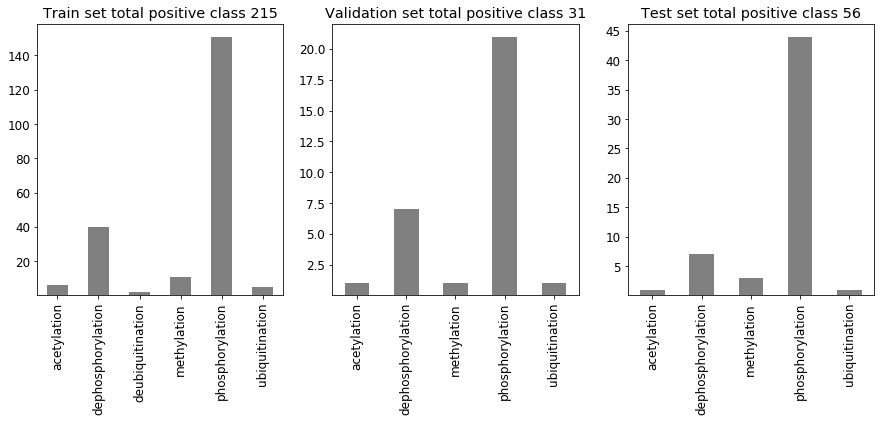

In [74]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as mtick


fig, ax = plt.subplots( 1,3, figsize=(15,5))



#fig, ax = plt.subplots( 7,1, figsize=(45,30))
c_ax= ax[0]
c_ax.set_title('Train set total positive class {}'.format(train.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
train.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')




c_ax = ax[1] 
c_ax.set_title('Validation set total positive class {}'.format(val.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
val.interactionType.value_counts().sort_index().plot.bar(ax=c_ax, color='gray')

c_ax = ax[2] 
c_ax.set_title('Test set total positive class {}'.format(test.shape[0]))
c_ax.yaxis.set_major_locator(plt.MaxNLocator( prune='both'))
test.interactionType.value_counts().sort_index().plot.bar(ax=c_ax,  color='gray')


plt.savefig('TrainTestValidationInteractionDistribution.eps', bbox_inches='tight')
plt.savefig('TrainTestValidationInteractionDistribution.png', bbox_inches='tight')


plt.show()

### Sample network

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


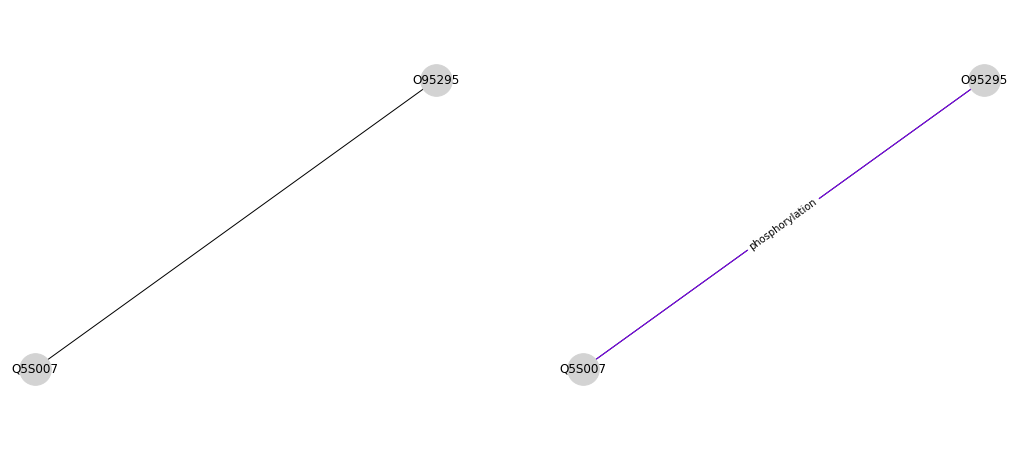

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import random

random.seed(a=78, version=2)

fig,ax=plt.subplots(1,2, figsize=(18,8))

G=nx.Graph()
# Add nodes and edges
G.add_edges_from(train.query(" participant2Id =='Q5S007' and participant1Id != participant2Id")
                 .apply(lambda x: ( x["participant1Id"],x["participant2Id"], {"type": x['interactionType']}), axis=1))


pos = nx.spring_layout(G,  seed=80)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[0])


edge_label = nx.get_edge_attributes(G,'type')

colors = {i:random.randint(0, 50) for i in train['interactionType'].unique()}
edge_colors = [ colors[l]  for _,l in edge_label.items()]

cmap=plt.cm.get_cmap("rainbow")
vmin = min(edge_colors)
vmax = max(edge_colors)

nx.draw(G, node_color='lightgrey', pos=pos, node_size=1000, with_labels = True, ax=ax[1])
nx.draw_networkx_edges(G, pos,  width=1.0, edge_color=edge_colors, edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax)

nx.draw_networkx_edge_labels(G, pos=pos,alpha=1, edge_labels = nx.get_edge_attributes(G,'type'), ax=ax[1])

plt.savefig('network.pdf', bbox_inches="tight")



plt.show()

### Generate negative samples

In [76]:

# def generate_negative_old(data):
#     import uuid
#     unique_pubmeds = data["pubmedId"].unique()
#     data_fake = pd.DataFrame(columns=data.columns)

#     num_fake_records = int( .50 * len(data))
#     #TODO: Randomise this, biased via
#     for u in unique_pubmeds:
#         fake_records = pd.DataFrame(data[ data.pubmedId != u]  ).sample(n=1) 
#         fake_records.loc[:, "interactionId"] =  fake_records.interactionId.astype(str) + "_" + str(uuid.uuid4() ) + "_" + "fake"
#         fake_records.loc[:,"isValid"] = 'False' 
#         ## Copy of the pubmeid abtract and the title from a id
#         fake_records.loc[:,"pubmedId"] = u
#         fake_records.loc[:, "pubmedTitle"] =  data[ data.pubmedId == u].iloc[0]["pubmedTitle"]
#         fake_records.loc[:, "pubmedabstract"] =  data[ data.pubmedId == u].iloc[0]["pubmedabstract"]


#         data_fake = data_fake.append(fake_records, ignore_index=True)
#         if len(data_fake) > num_fake_records:
#             break
            
#     return data_fake
  
    

In [77]:

def generate_negative_entity(data, enity_annotations_file):
    from dataformatters.gnormplusPubtatorReader import GnormplusPubtatorReader
    from datatransformer.gnormplusNegativeSamplesAugmentor import GnormplusNegativeSamplesAugmentor
    from datatransformer.ncbiGeneUniprotLocalDbMapper import NcbiGeneUniprotLocalDbMapper

    import os
    
 
    localdb = human_idmapping_dat
    with open(localdb, "r") as dbhandle:
        mapper = NcbiGeneUniprotLocalDbMapper(dbhandle, "GeneID") 
            
        #Read gnormplus identified entities
        reader = GnormplusPubtatorReader()
        with open(enity_annotations_file,"r") as handle:
            annotations_json = list(reader(handle))

        negative_samples_generator = GnormplusNegativeSamplesAugmentor(annotations_json, mapper)
        result = negative_samples_generator.transform(data)
        
        

        return result

In [78]:

def generate_negative_interaction(data):

    from datatransformer.interactionTypeNegativeSamplesAugmentor import InteractionTypeNegativeSamplesAugmentor

    import os
    
    negative_samples_generator = InteractionTypeNegativeSamplesAugmentor()
    result = negative_samples_generator.transform(data)


    return result

In [79]:
def generate_negative_missing_participant(data):


    import os
    
    data['isValid'] = data['isValid'].mask( (data['bothParticpantsExist'] == False) & (data['isValid'] == True) , False)


    return data

In [80]:
def plot_negative_distribution(train,val, test, heading, fig, ax  ):
    import matplotlib.pyplot as plt
    import matplotlib.ticker as mtick
    fig.suptitle(heading)
    #fig, ax = plt.subplots( 7,1, figsize=(45,30))
    c_ax= ax[0]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Training PPI {}".format( train.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    train.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[1]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Validation PPI {}".format(val.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    val.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



    c_ax= ax[2]
    c_ax.set_facecolor('xkcd:white')
    c_ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    c_ax.set_title( "Test PPI {}".format(test.shape[0]))
    c_ax.yaxis.set_major_locator(plt.FixedLocator(range(0,100, 10)))
    test.groupby(['interactionType', 'isValid']).size().groupby( level=0).apply(lambda x:
                                                     100 * x / float(x.sum())).unstack().plot.bar(ax=c_ax, hatch = '/')



   

#### Step1: Add negative entity pairs

In [81]:

train = generate_negative_entity(train, annotations_file)
test = generate_negative_entity(test,  annotations_file)
val = generate_negative_entity(val, annotations_file)



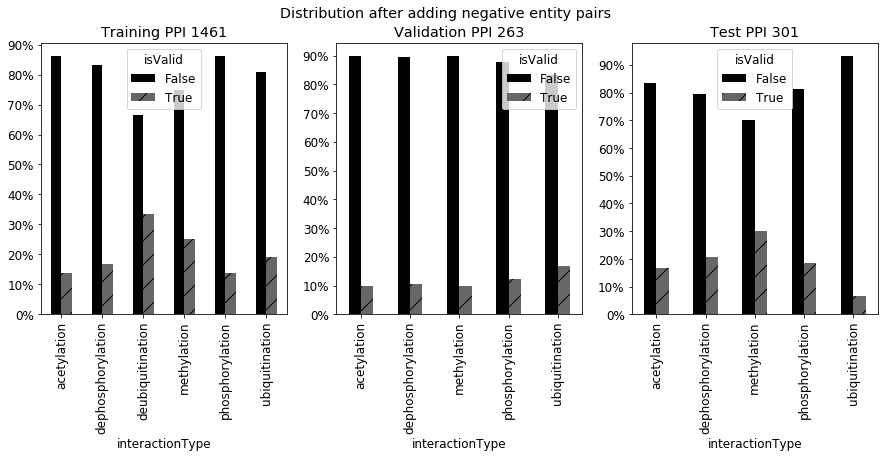

In [82]:
fig, ax = plt.subplots( 1,3, figsize=(15,5))

plt.style.use('grayscale')

plot_negative_distribution(train,  val, test, "Distribution after adding negative entity pairs",fig, ax)
plt.savefig("EntityNegativeSample.eps",bbox_inches = "tight")
plt.savefig("EntityNegativeSample.svg",bbox_inches = "tight")
plt.show()

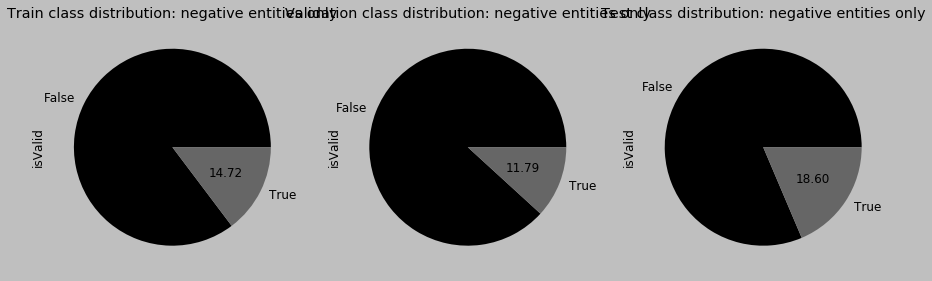

In [83]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(15,20))

ax[0].set_title('Train class distribution: negative entities only')
train.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[0])

ax[1].set_title('Validation class distribution: negative entities only')
val.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[1])


ax[2].set_title('Test class distribution: negative entities only')
test.isValid.value_counts().plot.pie(autopct='%.2f',  ax=ax[2])



plt.savefig("PositiveVsNegative_EntityOnly.png")

In [84]:
train_file ="train_unique_negative_entity_only.json"
train.to_json(train_file)

test_file ="test_unique_negative_entity_only.json"
test.to_json(test_file)

val_file = "val_unique_negative_entity_only.json"
val.to_json(val_file)



In [85]:


from helpers.s3_util import S3Util

S3Util().uploadfile(train_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(val_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-02-20 18:53:19,583 - helpers.s3_util - INFO - Uploading file train_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/train_unique_negative_entity_only.json
2021-02-20 18:53:31,510 - helpers.s3_util - INFO - Uploading file test_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/test_unique_negative_entity_only.json
2021-02-20 18:53:39,250 - helpers.s3_util - INFO - Uploading file val_unique_negative_entity_only.json s3://aegovan-data/processed_dataset/val_unique_negative_entity_only.json


In [86]:
train.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,37,6
dephosphorylation,198,40
deubiquitination,4,2
methylation,33,11
phosphorylation,953,151
ubiquitination,21,5


In [87]:
val.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,9,1
dephosphorylation,60,7
methylation,9,1
phosphorylation,149,21
ubiquitination,5,1


In [88]:
test.groupby(['interactionType', 'isValid']).size().unstack()

isValid,False,True
interactionType,,
acetylation,5,1
dephosphorylation,27,7
methylation,7,3
phosphorylation,192,44
ubiquitination,14,1


In [89]:
pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())

isValid,False,True
interactionType,,
acetylation,37,6
dephosphorylation,198,40
deubiquitination,4,2
methylation,33,11
phosphorylation,953,151
ubiquitination,21,5


In [90]:
t = pd.DataFrame(train.groupby(['interactionType', 'isValid']).size().unstack())
t.columns =["False", "True"]

v = pd.DataFrame(val.groupby(['interactionType', 'isValid']).size().unstack())
v.columns = ["False", "True"]

b = pd.DataFrame(test.groupby(['interactionType', 'isValid']).size().unstack())
b.columns = ["False", "True"]

m = t.merge(v, left_index = True, right_index=True, how="left", suffixes=('_train', '_val'))\
       .merge(b, left_index = True, right_index=True, how="left")\

m=m.fillna(0)

m.loc["Total"] = m.apply(lambda x: sum(x))

m["TotalFalse"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'false' in k.lower()]), axis=1)
m["TotalTrue"] =  m.apply(lambda x: sum( [ v for k,v in x.items() if 'true' in k.lower()]), axis=1)



print(m.astype('int32').to_latex())
    

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  False\_train &  True\_train &  False\_val &  True\_val &  False &  True &  TotalFalse &  TotalTrue \\
interactionType   &              &             &            &           &        &       &             &            \\
\midrule
acetylation       &           37 &           6 &          9 &         1 &      5 &     1 &          51 &          8 \\
dephosphorylation &          198 &          40 &         60 &         7 &     27 &     7 &         285 &         54 \\
deubiquitination  &            4 &           2 &          0 &         0 &      0 &     0 &           4 &          2 \\
methylation       &           33 &          11 &          9 &         1 &      7 &     3 &          49 &         15 \\
phosphorylation   &          953 &         151 &        149 &        21 &    192 &    44 &        1294 &        216 \\
ubiquitination    &           21 &           5 &          5 &         1 &     14 &     1 &          40 &          7 \\
Total         

In [91]:
feature_cols = ["pubmedId","pubmedabstract","annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id", "normalised_abstract", "participant1Id", "participant2Id", "gene_to_uniprot_map"]

derive_class_func = lambda r: r["interactionType"] if r["isValid"] else "other"


In [92]:

train_multiclass = train[ feature_cols]
train_multiclass["class"] = train.apply( derive_class_func, axis=1)

test_multiclass =  test[ feature_cols]
test_multiclass["class"] = test.apply( derive_class_func, axis=1)

val_multiclass =  val[ feature_cols]
val_multiclass["class"] = val.apply( derive_class_func, axis=1)

/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aeg/venv/PPI-typed-relation-extractor/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [93]:
feature_cols = ["pubmedId","pubmedabstract", "annotations", "num_unique_gene_normalised_id", "num_gene_normalised_id","normalised_abstract", "participant1Id", "participant2Id","gene_to_uniprot_map", "class"]


train_multiclass = train_multiclass[ feature_cols]
test_multiclass = test_multiclass[ feature_cols]
val_multiclass = val_multiclass[ feature_cols]




In [94]:
train_multiclass["class"].value_counts()

other                1246
phosphorylation       151
dephosphorylation      40
methylation            11
acetylation             6
ubiquitination          5
deubiquitination        2
Name: class, dtype: int64

In [95]:
test_multiclass["class"].value_counts()

other                245
phosphorylation       44
dephosphorylation      7
methylation            3
ubiquitination         1
acetylation            1
Name: class, dtype: int64

In [96]:
val_multiclass["class"].value_counts()

other                232
phosphorylation       21
dephosphorylation      7
methylation            1
ubiquitination         1
acetylation            1
Name: class, dtype: int64

In [97]:
train_multi_file="train_multiclass.json"
train_multiclass.to_json(train_multi_file)

test_multi_file="test_multiclass.json"
test_multiclass.to_json(test_multi_file)

val_multi_file="val_multiclass.json"
val_multiclass.to_json(val_multi_file)

In [98]:
val_multiclass.head(n=1)

,pubmedId,pubmedabstract,annotations,num_unique_gene_normalised_id,num_gene_normalised_id,normalised_abstract,participant1Id,participant2Id,gene_to_uniprot_map,class
0,17141222,"Regulation of growth factor dependent cell survival is crucial for development and disease progression. Here, we report a novel function of Src kinases as a negative regulator of platelet-derived growth factor (PDGF) dependent cell survival. We characterized a series of PDGF alpha receptor (PDGFRA) mutants, which lack the binding sites for Src, phosphatidylinositol 3'-kinase (PI3K), SHP-2 or phospholipase C-gamma. We found that PDGFRA-dependent cell survival was mainly mediated through activation of PI3K, and was negatively regulated by Src. Characterization of the downstream signaling events revealed that PI3K activates the protein kinase Akt, which in turn phosphorylates and thus inactivates proapoptotic Forkhead transcription factors. Src phosphorylates the ubiquitin-ligase c-Cbl, which is required for degradation of the activated receptor. Consequently, overexpression of c-Cbl prevented PDGFRA-mediated cell survival, whereas it did not affect this response, when Src was unable to associate with the receptor. This novel function of Src in antiapoptotic signaling introduces Src kinases as an interesting therapeutic target in apoptosis related diseases.","[{'start': '140', 'end': '143', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '292', 'end': '298', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '342', 'end': '345', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '347', 'end': '377', 'name': 'phosphatidylinositol 3'-kinase', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '379', 'end': '383', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '386', 'end': '391', 'name': 'SHP-2', 'type': 'Gene', 'normalised_id': '5781'}, {'start': '432', 'end': '438', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '505', 'end': '509', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '543', 'end': '546', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '614', 'end': '618', 'name': 'PI3K', 'type': 'Gene', 'normalised_id': '5294'}, {'start': '748', 'end': '751', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '788', 'end': '793', 'name': 'c-Cbl', 'type': 'Gene', 'normalised_id': '867'}, {'start': '888', 'end': '893', 'name': 'c-Cbl', 'type': 'Gene', 'normalised_id': '867'}, {'start': '904', 'end': '910', 'name': 'PDGFRA', 'type': 'Gene', 'normalised_id': '5156'}, {'start': '981', 'end': '984', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '1051', 'end': '1054', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}, {'start': '1093', 'end': '1096', 'name': 'Src', 'type': 'Gene', 'normalised_id': '6714'}]",5,17,"Regulation of growth factor dependent cell survival is crucial for development and disease progression. Here, we report a novel function of P12931 kinases as a negative regulator of platelet-derived growth factor (PDGF) dependent cell survival. We characterized a series of PDGF alpha receptor (P16234) mutants, which lack the binding sites for P12931, P48736 (P48736), Q06124 or phospholipase C-gamma. We found that P16234-dependent cell survival was mainly mediated through activation of P48736, and was negatively regulated by P12931. Characterization of the downstream signaling events revealed that P48736 activates the protein kinase Akt, which in turn phosphorylates and thus inactivates proapoptotic Forkhead transcription factors. P12931 phosphorylates the ubiquitin-ligase P22681, which is required for degradation of the activated receptor. Consequently, overexpression of P22681 prevented P16234-mediated cell survival, whereas it did not affect this response, when P12931 was unable to associate with the receptor. This novel function of P12931 in antiapoptotic signaling introduces 

In [99]:
from helpers.s3_util import S3Util

S3Util().uploadfile(val_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(test_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )
S3Util().uploadfile(train_multi_file, "{}/".format( s3_results_prefix.rstrip("/")) )

2021-02-20 18:53:47,705 - helpers.s3_util - INFO - Uploading file val_multiclass.json s3://aegovan-data/processed_dataset/val_multiclass.json
2021-02-20 18:53:54,865 - helpers.s3_util - INFO - Uploading file test_multiclass.json s3://aegovan-data/processed_dataset/test_multiclass.json
2021-02-20 18:54:05,167 - helpers.s3_util - INFO - Uploading file train_multiclass.json s3://aegovan-data/processed_dataset/train_multiclass.json


In [100]:
train_multiclass.sample(n=50).to_json("sample_train_multiclass.json")